### Anomoly Detection for Smart Home

In [2]:
!pip install shap

In [3]:
!pip install lime

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# XAI
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer


#### Loading the dataset

In [2]:
# List all txt files
file_list = glob.glob('C:/Users/akshi/Desktop/Masters/Carleton/Fall 25/IOT/IoT_proj/new_labeled_data/*.txt')
print(f"Found {len(file_list)} files")
if len(file_list) == 0:
    print("Warning: No files found! Check the path.")

Found 5 files


In [3]:
#only aruba 
df = pd.read_csv('C:/Users/akshi/Desktop/Masters/Carleton/Fall 25/IOT/IoT_proj/new_labeled_data/aruba.txt', delim_whitespace=True, header=None,
                     engine='python',
                     on_bad_lines='skip')
df.columns = ['Date','Time','Sensor','Value','Activity','Status']

C:\Users\akshi\AppData\Local\Temp\ipykernel_6716\3850375014.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('C:/Users/akshi/Desktop/Masters/Carleton/Fall 25/IOT/IoT_proj/new_labeled_data/aruba.txt', delim_whitespace=True, header=None,


In [4]:
df.isnull().sum()

Date              0
Time              0
Sensor            0
Value             0
Activity    1706604
Status      1706604
dtype: int64

In [5]:
# Clean Date and Time columns before conversion
# Remove any whitespace and normalize Unicode characters to standard spaces
df['Date'] = df['Date'].astype(str).str.strip()
df['Time'] = df['Time'].astype(str).str.strip()
# Normalize any Unicode whitespace to standard spaces (handles non-breaking spaces, etc.)
df['Date'] = df['Date'].apply(lambda x: ' '.join(x.split()) if pd.notna(x) else x)
df['Time'] = df['Time'].apply(lambda x: ' '.join(x.split()) if pd.notna(x) else x)

# Diagnostic: Check which rows will fail datetime conversion
df['Timestamp_temp'] = df['Date'] + ' ' + df['Time']
df['Timestamp_temp'] = pd.to_datetime(df['Timestamp_temp'], errors='coerce')

# Find rows where conversion failed
failed_rows = df[df['Timestamp_temp'].isna()]
print(f"Number of rows that failed datetime conversion: {len(failed_rows)}")
if len(failed_rows) > 0:
    print("\nProblematic rows:")
    print(failed_rows[['Date', 'Time', 'Sensor', 'Value']].head(10))
    print("\nUnique Date values in failed rows:")
    print(failed_rows['Date'].unique())
    print("\nUnique Time values in failed rows:")
    print(failed_rows['Time'].unique())
    
    # Detailed inspection of the problematic strings
    print("\nDetailed inspection of problematic strings:")
    for idx, row in failed_rows.iterrows():
        date_str = str(row['Date'])
        time_str = str(row['Time'])
        combined = date_str + ' ' + time_str
        print(f"\nRow {idx}:")
        print(f"  Date (repr): {repr(date_str)}")
        print(f"  Time (repr): {repr(time_str)}")
        print(f"  Combined (repr): {repr(combined)}")
        print(f"  Date length: {len(date_str)}, Time length: {len(time_str)}")
        # Try with explicit format
        try:
            parsed = pd.to_datetime(combined, format='%Y-%m-%d %H:%M:%S')
            print(f"  Parsed with explicit format: {parsed}")
        except Exception as e:
            print(f"  Failed with explicit format: {e}")

# Drop the temporary column
df = df.drop(columns=['Timestamp_temp'])


Number of rows that failed datetime conversion: 2

Problematic rows:
               Date      Time Sensor Value
679536   2011-01-29  09:22:15   M013    ON
1433288  2011-05-04  10:39:12   M008   OFF

Unique Date values in failed rows:
['2011-01-29' '2011-05-04']

Unique Time values in failed rows:
['09:22:15' '10:39:12']

Detailed inspection of problematic strings:

Row 679536:
  Date (repr): '2011-01-29'
  Time (repr): '09:22:15'
  Combined (repr): '2011-01-29 09:22:15'
  Date length: 10, Time length: 8
  Parsed with explicit format: 2011-01-29 09:22:15

Row 1433288:
  Date (repr): '2011-05-04'
  Time (repr): '10:39:12'
  Combined (repr): '2011-05-04 10:39:12'
  Date length: 10, Time length: 8
  Parsed with explicit format: 2011-05-04 10:39:12


In [6]:
# Combine Date and Time into Timestamp with proper cleaning
# Remove any non-standard whitespace and ensure single space separator
df['Timestamp'] = (df['Date'].astype(str).str.strip() + ' ' + 
                    df['Time'].astype(str).str.strip()).str.strip()

# Convert to datetime with explicit format to ensure consistent parsing
# First try with explicit format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# If explicit format failed for some rows, try without format (pandas inference)
# This handles edge cases like hidden characters or slight format variations
if df['Timestamp'].isnull().any():
    failed_mask = df['Timestamp'].isnull()
    # Reconstruct the timestamp string for failed rows
    failed_timestamps = (df.loc[failed_mask, 'Date'].astype(str).str.strip() + ' ' + 
                         df.loc[failed_mask, 'Time'].astype(str).str.strip()).str.strip()
    # Try parsing without explicit format
    df.loc[failed_mask, 'Timestamp'] = pd.to_datetime(failed_timestamps, errors='coerce')

# Check for any remaining failed conversions BEFORE dropping Date/Time columns
null_count = df['Timestamp'].isnull().sum()
if null_count > 0:
    print(f"Warning: {null_count} rows failed datetime conversion")
    print("These rows will have NaN in Timestamp column")
    # Show which rows failed (while Date/Time columns still exist)
    failed_rows = df[df['Timestamp'].isnull()]
    print("\nFailed rows:")
    print(failed_rows[['Date', 'Time', 'Sensor', 'Value']])
    print("\nYou may want to drop these rows or investigate further:")
    print("  df = df.dropna(subset=['Timestamp'])")
else:
    print("✓ All rows successfully converted to Timestamp!")

# Drop original Date and Time columns
df = df.drop(columns=['Date','Time'])

# Check null values after conversion
df.isnull().sum()

✓ All rows successfully converted to Timestamp!


Sensor             0
Value              0
Activity     1706604
Status       1706604
Timestamp          0
dtype: int64

In [7]:
df.sort_values('Timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Sensor,Value,Activity,Status,Timestamp
0,M003,ON,Sleeping,begin,2010-11-04 00:03:50.209589
1,M003,OFF,None,None,2010-11-04 00:03:57.399391
2,T002,21.5,None,None,2010-11-04 00:15:08.984841
3,T003,21,None,None,2010-11-04 00:30:19.185547
4,T004,21,None,None,2010-11-04 00:30:19.385336
...,...,...,...,...,...
1719553,T002,25.5,None,None,2011-06-11 23:42:59.285070
1719554,T001,23.5,None,None,2011-06-11 23:48:02.888409
1719555,T002,25,None,None,2011-06-11 23:48:02.988798
1719556,T002,25.5,None,None,2011-06-11 23:53:06.429200


In [ ]:
# # List all txt files
# file_list = glob.glob('C:/Users/akshi/Desktop/Masters/Carleton/Fall 25/IOT/IoT_proj/new_labeled_data/*.txt')

# # Load all files into a single DataFrame
# all_data = []
# for file in file_list:
#     # Read with flexible column handling
#     df = pd.read_csv(file, delim_whitespace=True, header=None,
#                      engine='python',
#                      on_bad_lines='skip')
    
#     # Handle variable number of columns
#     if df.shape[1] >= 4:
#         df.columns = ['Date', 'Time', 'Sensor', 'Value'] + [f'Extra_{i}' for i in range(df.shape[1] - 4)]
#         # Only keep the first 6 columns if they exist
#         if df.shape[1] >= 6:
#             df = df.iloc[:, :6]
#             df.columns = ['Date','Time','Sensor','Value','Activity','Status']
#         elif df.shape[1] == 5:
#             df.columns = ['Date','Time','Sensor','Value','Activity']
#             df['Status'] = None
#         else:
#             df.columns = ['Date','Time','Sensor','Value']
#             df['Activity'] = None
#             df['Status'] = None
    
#     df['Timestamp'] = df['Date'] + ' ' + df['Time']
#     df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce', infer_datetime_format=True) 
#     df = df.drop(columns=['Date','Time'])
#     all_data.append(df)

# # Combine all files
# df_all = pd.concat(all_data, ignore_index=True)
# df_all.sort_values('Timestamp', inplace=True)
# df_all.reset_index(drop=True, inplace=True)


In [8]:
# Forward fill the Activity column (handles None, NaN, and empty strings)
df['Activity'] = df['Activity'].replace('', None).ffill()
df

,Sensor,Value,Activity,Status,Timestamp
0,M003,ON,Sleeping,begin,2010-11-04 00:03:50.209589
1,M003,OFF,Sleeping,None,2010-11-04 00:03:57.399391
2,T002,21.5,Sleeping,None,2010-11-04 00:15:08.984841
3,T003,21,Sleeping,None,2010-11-04 00:30:19.185547
4,T004,21,Sleeping,None,2010-11-04 00:30:19.385336
...,...,...,...,...,...
1719553,T002,25.5,Sleeping,None,2011-06-11 23:42:59.285070
1719554,T001,23.5,Sleeping,None,2011-06-11 23:48:02.888409
1719555,T002,25,Sleeping,None,2011-06-11 23:48:02.988798
1719556,T002,25.5,Sleeping,None,2011-06-11 23:53:06.429200


In [9]:
# Filter data for 2011
df_2011 = df[df['Timestamp'].dt.year == 2011].copy()

print(f"2011 data shape: {df_2011.shape}")
print(f"Date range: {df_2011['Timestamp'].min()} to {df_2011['Timestamp'].max()}")

2011 data shape: (1263216, 5)
Date range: 2011-01-01 00:00:15.547042 to 2011-06-11 23:58:10.004834


In [10]:
# Sort the entire dataframe by Timestamp
df_2011.sort_values('Timestamp', inplace=True)
df_2011

,Sensor,Value,Activity,Status,Timestamp
456342,M009,ON,Relax,None,2011-01-01 00:00:15.547042
456343,M009,OFF,Relax,None,2011-01-01 00:00:18.750207
456344,T003,21.5,Relax,None,2011-01-01 00:00:31.268677
456345,T002,22,Relax,None,2011-01-01 00:00:31.404305
456346,M009,ON,Relax,None,2011-01-01 00:02:52.996266
...,...,...,...,...,...
1719553,T002,25.5,Sleeping,None,2011-06-11 23:42:59.285070
1719554,T001,23.5,Sleeping,None,2011-06-11 23:48:02.888409
1719555,T002,25,Sleeping,None,2011-06-11 23:48:02.988798
1719556,T002,25.5,Sleeping,None,2011-06-11 23:53:06.429200


In [11]:
df_2011['Sensor'].unique()

array(['M009', 'T003', 'T002', 'T004', 'T005', 'T001', 'M013', 'M020',
       'M012', 'M014', 'M018', 'M019', 'M015', 'M017', 'M021', 'M008',
       'M006', 'M007', 'M003', 'M005', 'M004', 'M002', 'M010', 'M022',
       'M001', 'M016', 'M011', 'M023', 'M024', 'M028', 'M026', 'M027',
       'M025', 'M029', 'D004', 'M030', 'D001', 'M031', 'D002',
       'LEAVEHOME', 'ENTERHOME'], dtype=object)

In [12]:
df_2011['Value'].unique()

array(['ON', 'OFF', '21.5', '22', '20', '21', '20.5', '26.5', '22.5',
       '23.5', '24.5', '23', '25.5', '24', '27.5', '26', '27', '25', '28',
       '19.5', 'OPEN', 'CLOSE', '29', '30.5', '28.5', '34.5', '36.5',
       '35.5', '35', '19', '18.5', '29.5', '31', '32', '32.5', '18',
       '17.5', '17', '31.5', '16.5', '30', '33', '33.5', '34', '36', '37',
       '37.5', '42', '38', '39', 'O', 'OF', '16', 'ONM026', '39.5',
       '41.5', '42.5', '43', '40.5', 'ONM009', 'ONM024', '180', '300',
       '6592', 'CLOSED'], dtype=object)

In [13]:
df_2011['Activity'].unique()

array(['Relax', 'Sleeping', 'Bed_to_Toilet', 'Meal_Preparation', 'Eating',
       'Wash_Dishes', 'Housekeeping', 'Leave_Home', 'Enter_Home', 'Work',
       'Respirate'], dtype=object)

#### Feature Engineering

In [14]:
# Create useful temporal features
df_2011['Hour'] = df_2011['Timestamp'].dt.hour
df_2011['Minute'] = df_2011['Timestamp'].dt.minute
df_2011['Second'] = df_2011['Timestamp'].dt.second
df_2011['DayOfWeek'] = df_2011['Timestamp'].dt.dayofweek

# Define sensor type
df_2011['SensorType'] = df_2011['Sensor'].str[0]  # M, D, L, T
df_2011

,Sensor,Value,Activity,Status,Timestamp,Hour,Minute,Second,DayOfWeek,SensorType
456342,M009,ON,Relax,None,2011-01-01 00:00:15.547042,0,0,15,5,M
456343,M009,OFF,Relax,None,2011-01-01 00:00:18.750207,0,0,18,5,M
456344,T003,21.5,Relax,None,2011-01-01 00:00:31.268677,0,0,31,5,T
456345,T002,22,Relax,None,2011-01-01 00:00:31.404305,0,0,31,5,T
456346,M009,ON,Relax,None,2011-01-01 00:02:52.996266,0,2,52,5,M
...,...,...,...,...,...,...,...,...,...,...
1719553,T002,25.5,Sleeping,None,2011-06-11 23:42:59.285070,23,42,59,5,T
1719554,T001,23.5,Sleeping,None,2011-06-11 23:48:02.888409,23,48,2,5,T
1719555,T002,25,Sleeping,None,2011-06-11 23:48:02.988798,23,48,2,5,T
1719556,T002,25.5,Sleeping,None,2011-06-11 23:53:06.429200,23,53,6,5,T


In [15]:
# Copy base DataFrame
df_2011['Value_raw'] = df_2011['Value']

# Create a numeric encoding only for binary sensors
df_2011['Binary_Value'] = df_2011['Value'].apply(
    lambda x: 1 if x in ['ON', 'OPEN'] else 0 if x in ['OFF', 'CLOSE'] else None
)

# Extract numeric readings (temperature etc.)
df_2011['Numeric_Value'] = pd.to_numeric(df_2011['Value'], errors='coerce')


In [16]:
df_2011

,Sensor,Value,Activity,Status,Timestamp,Hour,Minute,Second,DayOfWeek,SensorType,Value_raw,Binary_Value,Numeric_Value
456342,M009,ON,Relax,None,2011-01-01 00:00:15.547042,0,0,15,5,M,ON,1.0,NaN
456343,M009,OFF,Relax,None,2011-01-01 00:00:18.750207,0,0,18,5,M,OFF,0.0,NaN
456344,T003,21.5,Relax,None,2011-01-01 00:00:31.268677,0,0,31,5,T,21.5,NaN,21.5
456345,T002,22,Relax,None,2011-01-01 00:00:31.404305,0,0,31,5,T,22,NaN,22.0
456346,M009,ON,Relax,None,2011-01-01 00:02:52.996266,0,2,52,5,M,ON,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719553,T002,25.5,Sleeping,None,2011-06-11 23:42:59.285070,23,42,59,5,T,25.5,NaN,25.5
1719554,T001,23.5,Sleeping,None,2011-06-11 23:48:02.888409,23,48,2,5,T,23.5,NaN,23.5
1719555,T002,25,Sleeping,None,2011-06-11 23:48:02.988798,23,48,2,5,T,25,NaN,25.0
1719556,T002,25.5,Sleeping,None,2011-06-11 23:53:06.429200,23,53,6,5,T,25.5,NaN,25.5


In [ ]:
# #### Feature Engineering - Value Column Processing

# # Step 1: Normalize only ON and OFF corrupted entries
# def normalize_on_off(value):
#     """
#     Normalize corrupted ON/OFF entries like ON5, OFcF, OFFc to their base forms
#     Only handles ON and OFF, leaves other values as-is
#     """
#     if pd.isna(value):
#         return value
    
#     value_str = str(value).upper().strip()
    
#     # Check if it starts with ON (handles ON, ON5, ONc, ONcc, ON5c, ONc5, ONc5c, ONcc, ONM026, ONM009, ONM024, etc.)
#     if value_str.startswith('ON'):
#         return 'ON'
    
#     # Check if it starts with OFF (handles OFF, OFF5, OFFc, OFcF, OFFcc, OFF5cc, OFF5c, OFFc5, OFFccc5, OcFF, OF, etc.)
#     if value_str.startswith('OFF') or value_str.startswith('OcFF') or (value_str.startswith('OF') and len(value_str) <= 3):
#         return 'OFF'
    
#     # Return original value for everything else (OPEN, CLOSE, numbers, etc.)
#     return value

# # Apply normalization only to ON/OFF
# df_all['Value_normalized'] = df_all['Value'].apply(normalize_on_off)

# # Step 2: Create Binary_Value for ON/OFF/OPEN/CLOSE
# df_all['Binary_Value'] = df_all['Value_normalized'].apply(
#     lambda x: 1 if str(x).upper() in ['ON', 'OPEN'] else 0 if str(x).upper() in ['OFF', 'CLOSE', 'CLOSED'] else None
# )

# # Step 3: Extract numeric readings (temperature, etc.)
# df_all['Numeric_Value'] = pd.to_numeric(df_all['Value_normalized'], errors='coerce')

# # Display summary
# print("Value column processing complete!")
# print(f"\nBinary values distribution:")
# print(df_all['Binary_Value'].value_counts())
# print(f"\nNumeric values range: {df_all['Numeric_Value'].min():.2f} to {df_all['Numeric_Value'].max():.2f}")
# print(f"\nNormalized Value unique values (sample):")
# print(df_all['Value_normalized'].value_counts().head(20))

Value column processing complete!

Binary values distribution:
0.0    2096026
1.0    2077558
Name: Binary_Value, dtype: int64

Numeric values range: 12.50 to 6592.00

Normalized Value unique values (sample):
OFF     2091440
ON      2072998
23        20440
23.5      20294
22.5      19353
24        18057
22        17773
21.5      16046
24.5      15765
21        13452
25        12363
20.5      11761
20        10238
25.5      10076
19.5       8700
26         7735
19         7041
18.5       6313
26.5       6043
18         4594
Name: Value_normalized, dtype: int64


In [17]:
df_2011

,Sensor,Value,Activity,Status,Timestamp,Hour,Minute,Second,DayOfWeek,SensorType,Value_raw,Binary_Value,Numeric_Value
456342,M009,ON,Relax,None,2011-01-01 00:00:15.547042,0,0,15,5,M,ON,1.0,NaN
456343,M009,OFF,Relax,None,2011-01-01 00:00:18.750207,0,0,18,5,M,OFF,0.0,NaN
456344,T003,21.5,Relax,None,2011-01-01 00:00:31.268677,0,0,31,5,T,21.5,NaN,21.5
456345,T002,22,Relax,None,2011-01-01 00:00:31.404305,0,0,31,5,T,22,NaN,22.0
456346,M009,ON,Relax,None,2011-01-01 00:02:52.996266,0,2,52,5,M,ON,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719553,T002,25.5,Sleeping,None,2011-06-11 23:42:59.285070,23,42,59,5,T,25.5,NaN,25.5
1719554,T001,23.5,Sleeping,None,2011-06-11 23:48:02.888409,23,48,2,5,T,23.5,NaN,23.5
1719555,T002,25,Sleeping,None,2011-06-11 23:48:02.988798,23,48,2,5,T,25,NaN,25.0
1719556,T002,25.5,Sleeping,None,2011-06-11 23:53:06.429200,23,53,6,5,T,25.5,NaN,25.5


In [18]:
df_2011.drop('Value_raw',axis=1,inplace=True)

In [19]:
df_2011

,Sensor,Value,Activity,Status,Timestamp,Hour,Minute,Second,DayOfWeek,SensorType,Binary_Value,Numeric_Value
456342,M009,ON,Relax,None,2011-01-01 00:00:15.547042,0,0,15,5,M,1.0,NaN
456343,M009,OFF,Relax,None,2011-01-01 00:00:18.750207,0,0,18,5,M,0.0,NaN
456344,T003,21.5,Relax,None,2011-01-01 00:00:31.268677,0,0,31,5,T,NaN,21.5
456345,T002,22,Relax,None,2011-01-01 00:00:31.404305,0,0,31,5,T,NaN,22.0
456346,M009,ON,Relax,None,2011-01-01 00:02:52.996266,0,2,52,5,M,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1719553,T002,25.5,Sleeping,None,2011-06-11 23:42:59.285070,23,42,59,5,T,NaN,25.5
1719554,T001,23.5,Sleeping,None,2011-06-11 23:48:02.888409,23,48,2,5,T,NaN,23.5
1719555,T002,25,Sleeping,None,2011-06-11 23:48:02.988798,23,48,2,5,T,NaN,25.0
1719556,T002,25.5,Sleeping,None,2011-06-11 23:53:06.429200,23,53,6,5,T,NaN,25.5


In [20]:
df_sample = df_2011.tail(50000)
df_sample['Activity'].unique()

array(['Relax', 'Leave_Home', 'Enter_Home', 'Meal_Preparation',
       'Sleeping', 'Bed_to_Toilet', 'Eating', 'Work'], dtype=object)

In [21]:
# Sort by Timestamp and set it as the index
df_sample.sort_values('Timestamp', inplace=True)
df_sample.set_index('Timestamp', inplace=True)


C:\Users\akshi\AppData\Local\Temp\ipykernel_6716\3745862651.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample.sort_values('Timestamp', inplace=True)


In [22]:
df_sample

,Sensor,Value,Activity,Status,Hour,Minute,Second,DayOfWeek,SensorType,Binary_Value,Numeric_Value
Timestamp,,,,,,,,,,,
2011-06-05 08:29:08.372554,M027,ON,Relax,None,8,29,8,6,M,1.0,NaN
2011-06-05 08:29:10.094509,M027,OFF,Relax,None,8,29,10,6,M,0.0,NaN
2011-06-05 08:29:12.086610,M028,ON,Relax,None,8,29,12,6,M,1.0,NaN
2011-06-05 08:29:14.319754,M022,ON,Relax,None,8,29,14,6,M,1.0,NaN
2011-06-05 08:29:14.722639,M026,OFF,Relax,None,8,29,14,6,M,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2011-06-11 23:42:59.285070,T002,25.5,Sleeping,None,23,42,59,5,T,NaN,25.5
2011-06-11 23:48:02.888409,T001,23.5,Sleeping,None,23,48,2,5,T,NaN,23.5
2011-06-11 23:48:02.988798,T002,25,Sleeping,None,23,48,2,5,T,NaN,25.0


In [23]:
# Diagnostic: Understand why aggregation increases row count
print("=== Understanding Row Count Increase ===\n")

print(f"Original df_sample size: {len(df_sample):,} rows")
print(f"Time range: {df_sample.index.min()} to {df_sample.index.max()}")
time_span = df_sample.index.max() - df_sample.index.min()
print(f"Time span: {time_span}")
print(f"Time span in minutes: {time_span.total_seconds() / 60:.1f} minutes\n")

# Count unique sensors
unique_sensors = df_sample['Sensor'].nunique()
print(f"Number of unique sensors: {unique_sensors}")

# Calculate expected rows after resampling
# resample('1min') creates one row per minute for each sensor group
expected_minutes = int(time_span.total_seconds() / 60) + 1  # +1 to include both endpoints
expected_rows = unique_sensors * expected_minutes
print(f"\nExpected rows after resampling:")
print(f"  - Minutes in time range: ~{expected_minutes:,}")
print(f"  - Unique sensors: {unique_sensors}")
print(f"  - Expected total rows: {unique_sensors} × {expected_minutes:,} = ~{expected_rows:,} rows")
print(f"\nNote: resample('1min') creates a row for EVERY 1-minute interval")
print(f"      for EACH sensor, even if there's no data in that minute.")
print(f"      This is why you get more rows than the original 50,000.")


=== Understanding Row Count Increase ===

Original df_sample size: 50,000 rows
Time range: 2011-06-05 08:29:08.372554 to 2011-06-11 23:58:10.004834
Time span: 6 days 15:29:01.632280
Time span in minutes: 9569.0 minutes

Number of unique sensors: 39

Expected rows after resampling:
  - Minutes in time range: ~9,570
  - Unique sensors: 39
  - Expected total rows: 39 × 9,570 = ~373,230 rows

Note: resample('1min') creates a row for EVERY 1-minute interval
      for EACH sensor, even if there's no data in that minute.
      This is why you get more rows than the original 50,000.


In [ ]:
# # Randomly sample 50,000 rows from your final dataframe
# sample_df = df_all.sample(n=50000, random_state=42)


# # Check the shape
# print(sample_df.shape)
# sample_df.head()


(50000, 11)


,Sensor,Value,Activity,Status,Hour,Minute,Second,DayOfWeek,SensorType,Binary_Value,Numeric_Value
0,M016,OFF,Enter_Home,None,19,38,54,3,M,0.0,NaN
1,T004,20,Meal_Preparation,None,9,12,24,5,T,NaN,20.0
2,M009,OFF,Relax,None,15,48,2,2,M,0.0,NaN
3,M010,OFF,Enter_Home,None,17,51,13,4,M,0.0,NaN
4,M007,OFF,Meal_Preparation,None,11,8,19,3,M,0.0,NaN


In [24]:
# Define aggregation function per sensor type
window_size = '1min'

# Aggregate with numeric values and binary value counts
agg_df = df_sample.groupby(['Sensor', 'SensorType']).resample(window_size).agg({
    'Numeric_Value': ['sum', 'mean', 'max'],
    'Binary_Value': ['sum', lambda x: (x == 0).sum()]  # sum gives count of 1s, lambda gives count of 0s
}).reset_index()

# Flatten multi-index columns
agg_df.columns = ['SensorType','Sensor','Timestamp', 'Sum', 'Mean', 'Max', 'Binary_Count_1', 'Binary_Count_0']


In [25]:
agg_df

,SensorType,Sensor,Timestamp,Sum,Mean,Max,Binary_Count_1,Binary_Count_0
0,D001,D,2011-06-06 05:40:00,0.0,NaN,NaN,1.0,0
1,D001,D,2011-06-06 05:41:00,0.0,NaN,NaN,0.0,1
2,D001,D,2011-06-06 05:42:00,0.0,NaN,NaN,0.0,0
3,D001,D,2011-06-06 05:43:00,0.0,NaN,NaN,0.0,0
4,D001,D,2011-06-06 05:44:00,0.0,NaN,NaN,0.0,0
...,...,...,...,...,...,...,...,...
356155,T005,T,2011-06-11 23:33:00,0.0,NaN,NaN,0.0,0
356156,T005,T,2011-06-11 23:34:00,0.0,NaN,NaN,0.0,0
356157,T005,T,2011-06-11 23:35:00,0.0,NaN,NaN,0.0,0
356158,T005,T,2011-06-11 23:36:00,0.0,NaN,NaN,0.0,0


In [26]:
# Replace NaN in Mean column with integer value of Binary_Count_1
agg_df['Mean'] = agg_df['Mean'].fillna(agg_df['Binary_Count_1'].astype(int))
# Check how many were replaced
replaced_count = agg_df['Mean'].isna().sum()
print(f"NaN values in Mean after replacement: {replaced_count}")

# Show some examples
print("\nSample rows where Mean was replaced:")
print(agg_df[agg_df['Mean'] == agg_df['Binary_Count_1']].head())

NaN values in Mean after replacement: 0

Sample rows where Mean was replaced:
  SensorType Sensor           Timestamp  Sum  Mean  Max  Binary_Count_1  \
0       D001      D 2011-06-06 05:40:00  0.0   1.0  NaN             1.0   
1       D001      D 2011-06-06 05:41:00  0.0   0.0  NaN             0.0   
2       D001      D 2011-06-06 05:42:00  0.0   0.0  NaN             0.0   
3       D001      D 2011-06-06 05:43:00  0.0   0.0  NaN             0.0   
4       D001      D 2011-06-06 05:44:00  0.0   0.0  NaN             0.0   

   Binary_Count_0  
0               0  
1               1  
2               0  
3               0  
4               0  


In [28]:
# Pivot sensors into columns (wide format) for Sum
pivot_df = agg_df.pivot_table(
    index='Timestamp',
    columns='SensorType',
    values='Mean',
    fill_value=0
).reset_index()

In [29]:
# Convert columns starting with 'M' and 'D' (but not 'T') to integers
# Get all column names that start with M or D but not T
cols_to_convert = [col for col in pivot_df.columns 
                   if (col.startswith('M') or col.startswith('D')) 
                   and not col.startswith('T')]
print(f"Converting {len(cols_to_convert)} columns to int: {cols_to_convert[:10]}...")  # Show first 10
# Convert to int (handles NaN by converting to 0 first, then to int)
pivot_df[cols_to_convert] = pivot_df[cols_to_convert].fillna(0).astype(int)
print("Conversion complete!")


Converting 34 columns to int: ['D001', 'D002', 'D004', 'M001', 'M002', 'M003', 'M004', 'M005', 'M006', 'M007']...
Conversion complete!


In [30]:
pivot_df

SensorType,Timestamp,D001,D002,D004,M001,M002,M003,M004,M005,M006,...,M027,M028,M029,M030,M031,T001,T002,T003,T004,T005
0,2011-06-05 08:29:00,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0
1,2011-06-05 08:30:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
2,2011-06-05 08:31:00,0,0,0,0,0,0,1,2,1,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
3,2011-06-05 08:32:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
4,2011-06-05 08:33:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9565,2011-06-11 23:54:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
9566,2011-06-11 23:55:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
9567,2011-06-11 23:56:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
9568,2011-06-11 23:57:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0


In [31]:
pivot_df['Hour'] = pivot_df['Timestamp'].dt.hour
pivot_df['DayOfWeek'] = pivot_df['Timestamp'].dt.dayofweek
pivot_df['IsNight'] = pivot_df['Hour'].apply(lambda x: 1 if x >= 22 or x < 6 else 0)
pivot_df['D001'].value_counts()

D001
0    9563
1       6
2       1
Name: count, dtype: int64

In [ ]:
# # Example rule: motion detected during Sleeping = intrusion
# motion_sensors = [col for col in pivot_df.columns if col.startswith('M')]
# pivot_df['Intrusion'] = 0

# # Merge activity labels to pivot table
# activity_df = df_sample[['Activity']].resample(window_size).agg(lambda x: x.mode()[0] if not x.empty else np.nan)
# pivot_df = pivot_df.merge(activity_df, left_on='Timestamp', right_on='Timestamp', how='left')

# # Define intrusion: motion during Sleeping or Leave_Home
# pivot_df.loc[(pivot_df[motion_sensors].sum(axis=1) > 0) & 
#              (pivot_df['Activity'].isin(['Sleeping','Leave_Home'])), 'Intrusion'] = 1


In [32]:
# Example rule: motion detected during Sleeping = intrusion
motion_sensors = [col for col in pivot_df.columns if col.startswith('M')]
pivot_df['Intrusion'] = 0

# Merge activity labels to pivot table
# Reset index to make Timestamp a column for merging
activity_df = df_sample[['Activity']].resample(window_size).first().reset_index()

# Forward fill NaN values
activity_df['Activity'] = activity_df['Activity'].ffill()

# Merge activity labels to pivot table
pivot_df = pivot_df.merge(activity_df, on='Timestamp', how='left')

# Forward fill any remaining NaN (handles cases where pivot_df has timestamps not in activity_df)
pivot_df['Activity'] = pivot_df['Activity'].ffill()

# Define intrusion: motion during Sleeping or Leave_Home
pivot_df.loc[(pivot_df[motion_sensors].sum(axis=1) > 0) & 
             (pivot_df['Activity'].isin(['Sleeping','Leave_Home'])), 'Intrusion'] = 1

In [33]:
pivot_df['Activity'].unique()

array(['Relax', 'Leave_Home', 'Enter_Home', 'Meal_Preparation',
       'Sleeping', 'Bed_to_Toilet', 'Eating', 'Work'], dtype=object)

In [34]:
df_sample['Activity'].unique()

array(['Relax', 'Leave_Home', 'Enter_Home', 'Meal_Preparation',
       'Sleeping', 'Bed_to_Toilet', 'Eating', 'Work'], dtype=object)

In [35]:
pivot_df['Intrusion'].value_counts()

Intrusion
0    9412
1     158
Name: count, dtype: int64

In [79]:
# Features
X = pivot_df.drop(columns=['Timestamp','Intrusion','Activity'])
X.fillna(0, inplace=True)  # handle NaNs
y = pivot_df['Intrusion']

# Standardize features (optional for tree-based models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [80]:
X

,D001,D002,D004,M001,M002,M003,M004,M005,M006,M007,...,M030,M031,T001,T002,T003,T004,T005,Hour,DayOfWeek,IsNight
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,8,6,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,8,6,0
2,0,0,0,0,0,0,1,2,1,2,...,0,0,0.0,0.0,0.0,0.0,0.0,8,6,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,8,6,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,8,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9565,0,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,23,5,1
9566,0,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,23,5,1
9567,0,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,23,5,1
9568,0,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,23,5,1


In [81]:
y_train.value_counts()

Intrusion
0    7530
1     126
Name: count, dtype: int64

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1882
           1       0.96      0.81      0.88        32

    accuracy                           1.00      1914
   macro avg       0.98      0.91      0.94      1914
weighted avg       1.00      1.00      1.00      1914



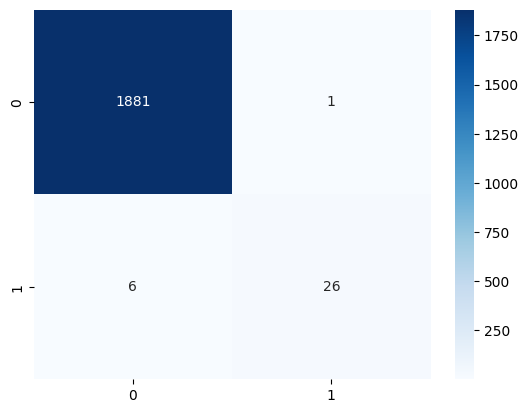

In [82]:
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
# # Initialize SHAP explainer
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)

# # Summary plot
# shap.summary_plot(shap_values[1], X_test, feature_names=X.columns)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [ ]:
# # For binary classification with TreeExplainer
# # shap_values might be a list of arrays
# %matplotlib inline
# if isinstance(shap_values, list):
#     print(f"shap_values is a list with {len(shap_values)} elements")
#     print(f"shap_values[0] shape: {shap_values[0].shape}")
#     print(f"shap_values[1] shape: {shap_values[1].shape}")
    
#     # Use the one that matches X_test
#     if shap_values[1].shape[1] == X_test.shape[1]:
#         shap.summary_plot(shap_values[1], X_test, feature_names=X.columns)
#     else:
#         # Use shap_values[0] or the full shap_values
#         shap.summary_plot(shap_values[0], X_test, feature_names=X.columns)

# plt.show()

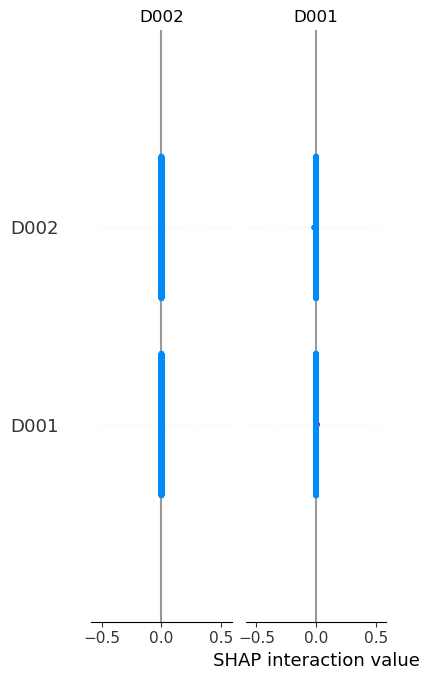

In [ ]:
# # Instead of shap_values[1], use shap_values directly
# shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [ ]:
# import pandas as pd
# import numpy as np

# # shap_values is 3D: (samples, features, classes)
# # Select class 1 for binary classification (positive class)
# shap_values_2d = shap_values[:, :, 1]

# # Create DataFrame
# shap_df = pd.DataFrame(shap_values_2d, columns=X.columns)

# # View
# print("SHAP values for each feature (class 1):")
# print(shap_df.head())



SHAP values for each feature (class 1):
       D001          D002      D004      M001      M002      M003      M004  \
0  0.000003  7.695333e-07 -0.001156 -0.000599 -0.172850 -0.236747 -0.021115   
1  0.000003  7.695333e-07 -0.001156 -0.000599 -0.172850 -0.236747 -0.021115   
2  0.000003  7.695333e-07 -0.001156 -0.000599 -0.172850 -0.236747 -0.021115   
3  0.000003  7.695333e-07 -0.001156 -0.000599 -0.172850 -0.236747 -0.021115   
4  0.000002  3.314280e-07 -0.000442 -0.003813 -0.045382  0.060075  0.009625   

       M005      M006      M007  ...      M027      M028      M029      M030  \
0 -0.004576 -0.001348 -0.016226  ...  0.000059 -0.000819 -0.007205 -0.010172   
1 -0.004576 -0.001348 -0.016226  ...  0.000059 -0.000819 -0.007205 -0.010172   
2 -0.004576 -0.001348 -0.016226  ...  0.000059 -0.000819 -0.007205 -0.010172   
3 -0.004576 -0.001348 -0.016226  ...  0.000059 -0.000819 -0.007205 -0.010172   
4 -0.063706 -0.083782 -0.123135  ...  0.000031 -0.000265 -0.001212 -0.001799   

    

In [79]:
# Mean SHAP value for each feature across all samples
mean_shap = shap_df.mean()
print("Mean SHAP values per feature:")
print(mean_shap.sort_values(ascending=False))

Mean SHAP values per feature:
M031    3.371757e-06
D002    7.368401e-07
D001   -5.916602e-06
M025   -1.255771e-05
M027   -2.415199e-05
M026   -2.591793e-05
T005   -3.339223e-04
T001   -5.455490e-04
M028   -9.606336e-04
T004   -1.030891e-03
M024   -1.407028e-03
D004   -1.418795e-03
T003   -1.471438e-03
M023   -1.504269e-03
M016   -1.706976e-03
M022   -2.030299e-03
M010   -2.049137e-03
M017   -2.246947e-03
M001   -2.270716e-03
M012   -3.094983e-03
M013   -3.225904e-03
M008   -3.351342e-03
T002   -3.510337e-03
M014   -3.556743e-03
M006   -3.687274e-03
M021   -3.923377e-03
M015   -4.424930e-03
M011   -4.669169e-03
M018   -4.767462e-03
M029   -5.260097e-03
M009   -6.150185e-03
M005   -6.589847e-03
M019   -7.277194e-03
M030   -7.796639e-03
M020   -9.520179e-03
M004   -1.515057e-02
M007   -1.897845e-02
M002   -1.512391e-01
M003   -1.952943e-01
dtype: float64


In [80]:
import shap
import pandas as pd
import numpy as np

# Calculate mean ABSOLUTE SHAP (what the plot shows)
mean_abs_shap = pd.Series(np.abs(shap_values[:, :, 1]).mean(axis=0), index=X.columns)
print("Mean ABSOLUTE SHAP values (what the plot shows):")
print(mean_abs_shap.sort_values(ascending=False).head(10))

Mean ABSOLUTE SHAP values (what the plot shows):
M003    0.207186
M002    0.155829
M004    0.020912
M009    0.019822
M007    0.019019
M020    0.009580
M030    0.009108
M019    0.007436
M010    0.006809
M005    0.006806
dtype: float64


In [ ]:
# Mean SHAP value for each feature across all samples
mean_shap = shap_df.mean()
print("Mean SHAP values per feature:")
print(mean_shap.sort_values(ascending=False))

In [81]:
# Check D001 and D002
print("D001 - Mean SHAP:", shap_values[:, :, 1][:, X.columns.get_loc('D001')].mean())
print("D001 - Mean ABS SHAP:", np.abs(shap_values[:, :, 1][:, X.columns.get_loc('D001')]).mean())

print("\nD002 - Mean SHAP:", shap_values[:, :, 1][:, X.columns.get_loc('D002')].mean())
print("D002 - Mean ABS SHAP:", np.abs(shap_values[:, :, 1][:, X.columns.get_loc('D002')]).mean())

print("\nM031 - Mean SHAP:", shap_values[:, :, 1][:, X.columns.get_loc('M031')].mean())
print("M031 - Mean ABS SHAP:", np.abs(shap_values[:, :, 1][:, X.columns.get_loc('M031')]).mean())

D001 - Mean SHAP: -5.916601516309039e-06
D001 - Mean ABS SHAP: 1.2323465644589829e-05

D002 - Mean SHAP: 7.368401414488331e-07
D002 - Mean ABS SHAP: 9.771278810645896e-07

M031 - Mean SHAP: 3.3717565071645585e-06
M031 - Mean ABS SHAP: 1.3993975543627628e-05


In [47]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)

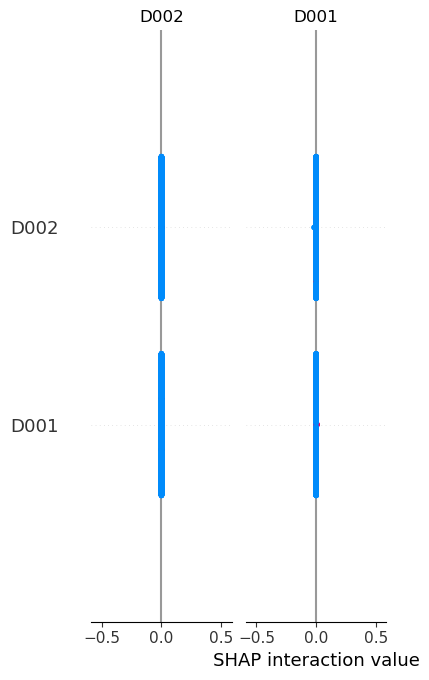

In [85]:
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X.columns)


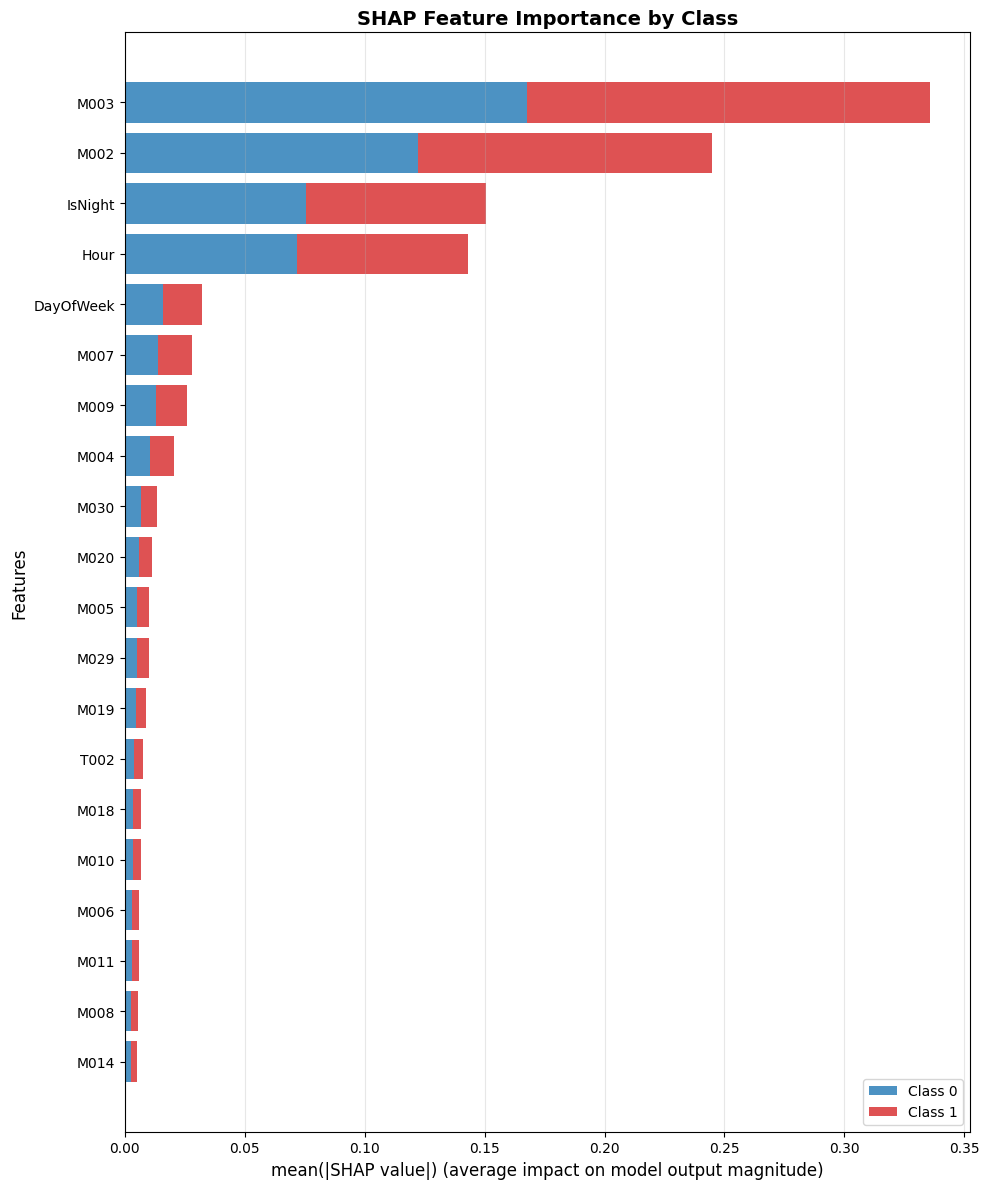

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Calculate mean absolute SHAP for both classes
mean_abs_shap_class0 = pd.Series(np.abs(shap_values[:, :, 0]).mean(axis=0), index=X.columns)
mean_abs_shap_class1 = pd.Series(np.abs(shap_values[:, :, 1]).mean(axis=0), index=X.columns)

# Combine into DataFrame
shap_importance = pd.DataFrame({
    'Class_0': mean_abs_shap_class0,
    'Class_1': mean_abs_shap_class1
})

# Calculate total importance for sorting
shap_importance['Total'] = shap_importance['Class_0'] + shap_importance['Class_1']
shap_importance = shap_importance.sort_values('Total', ascending=True)

# Plot stacked horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 12))

# Get top N features (e.g., top 20)
top_n = 20
shap_top = shap_importance.tail(top_n)

# Create stacked bars
ax.barh(shap_top.index, shap_top['Class_0'], label='Class 0', color='#1f77b4', alpha=0.8)
ax.barh(shap_top.index, shap_top['Class_1'], left=shap_top['Class_0'], 
        label='Class 1', color='#d62728', alpha=0.8)

ax.set_xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('SHAP Feature Importance by Class', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [49]:
mean_abs_shap_class0.sort_values(ascending=False).head(10)

M003         0.167791
M002         0.122417
IsNight      0.075357
Hour         0.071581
DayOfWeek    0.015977
M007         0.013942
M009         0.012881
M004         0.010331
M030         0.006641
M020         0.005672
dtype: float64

In [50]:
mean_abs_shap_class1.sort_values(ascending=False).head(10)

M003         0.167791
M002         0.122417
IsNight      0.075357
Hour         0.071581
DayOfWeek    0.015977
M007         0.013942
M009         0.012881
M004         0.010331
M030         0.006641
M020         0.005672
dtype: float64

In [51]:
# Check if they're negatives of each other (before taking absolute)
mean_shap_class0 = shap_values[:, :, 0].mean(axis=0)
mean_shap_class1 = shap_values[:, :, 1].mean(axis=0)

print("Mean SHAP Class 0 (first 5 features):")
print(mean_shap_class0[:5])
print("\nMean SHAP Class 1 (first 5 features):")
print(mean_shap_class1[:5])
print("\nAre they approximately negatives?")
print(np.allclose(mean_shap_class0, -mean_shap_class1, atol=1e-6))

Mean SHAP Class 0 (first 5 features):
[-1.60239005e-07  0.00000000e+00  1.47823290e-03  7.46179133e-04
  1.18804172e-01]

Mean SHAP Class 1 (first 5 features):
[ 1.60239005e-07  0.00000000e+00 -1.47823290e-03 -7.46179133e-04
 -1.18804172e-01]

Are they approximately negatives?
True


In [93]:
# Use mean SHAP (not absolute) to see positive/negative contributions
shap_importance = pd.DataFrame({
    'Class_0': shap_values[:, :, 0].mean(axis=0),
    'Class_1': shap_values[:, :, 1].mean(axis=0)
}, index=X.columns)

# They should be approximately negatives
print("Mean SHAP (not absolute):")
print(shap_importance.head(10))

Mean SHAP (not absolute):
           Class_0       Class_1
D001  5.916602e-06 -5.916602e-06
D002 -7.368401e-07  7.368401e-07
D004  1.418795e-03 -1.418795e-03
M001  2.270716e-03 -2.270716e-03
M002  1.512391e-01 -1.512391e-01
M003  1.952943e-01 -1.952943e-01
M004  1.515057e-02 -1.515057e-02
M005  6.589847e-03 -6.589847e-03
M006  3.687274e-03 -3.687274e-03
M007  1.897845e-02 -1.897845e-02


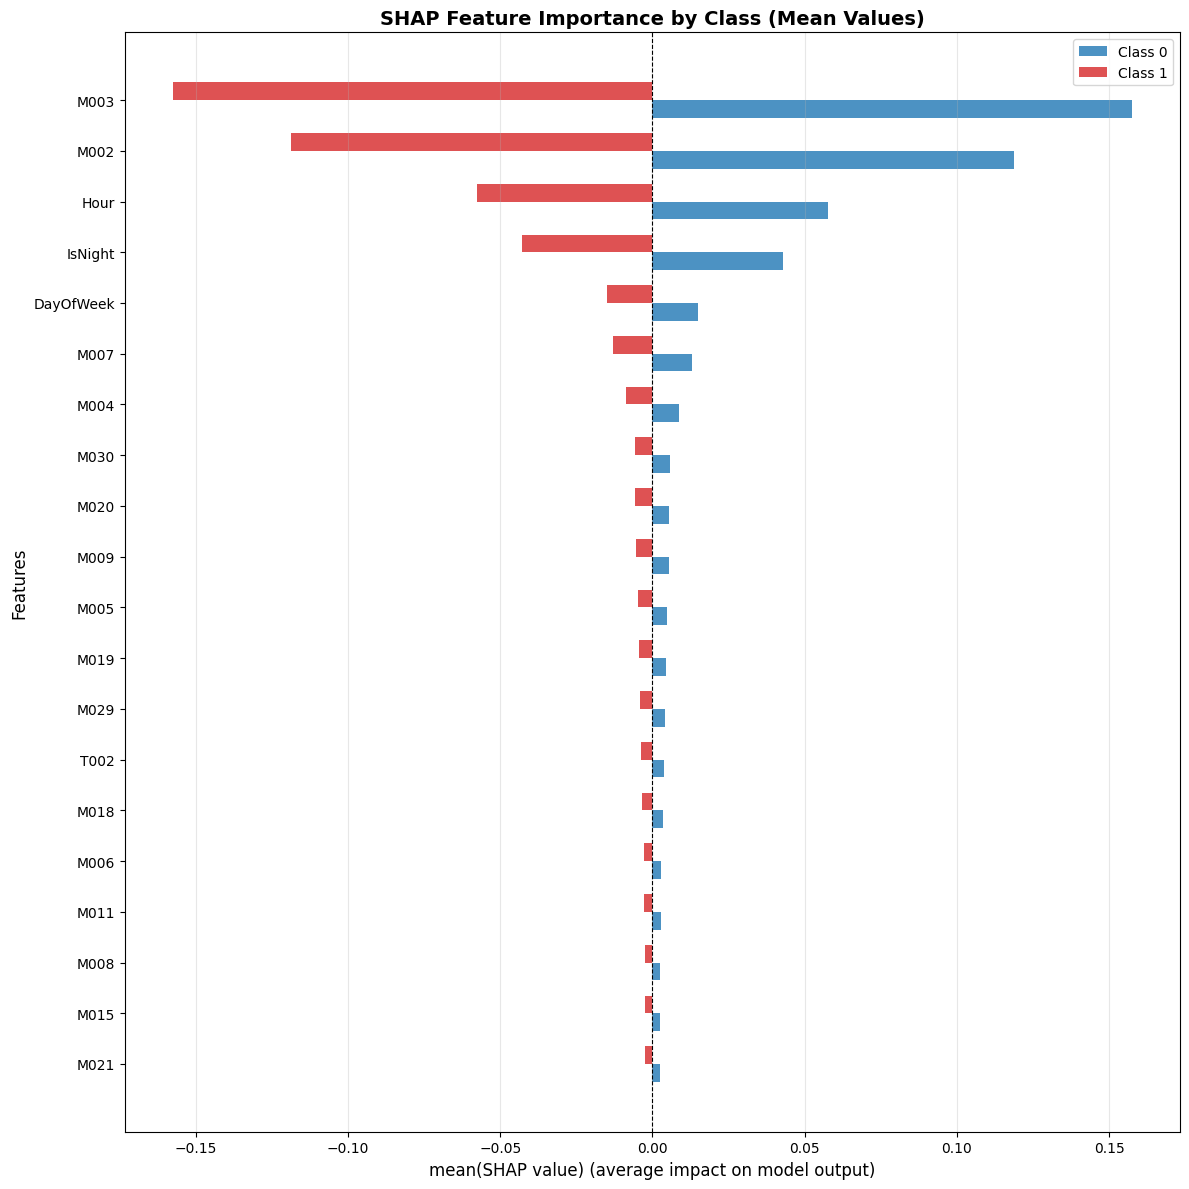

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Calculate mean SHAP for both classes (not absolute)
mean_shap_class0 = pd.Series(shap_values[:, :, 0].mean(axis=0), index=X.columns)
mean_shap_class1 = pd.Series(shap_values[:, :, 1].mean(axis=0), index=X.columns)

# Combine into DataFrame
shap_importance = pd.DataFrame({
    'Class_0': mean_shap_class0,
    'Class_1': mean_shap_class1
})

# Calculate total absolute importance for sorting
shap_importance['Total_Abs'] = np.abs(shap_importance['Class_0']) + np.abs(shap_importance['Class_1'])
shap_importance = shap_importance.sort_values('Total_Abs', ascending=True)

# Plot side-by-side horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 12))

# Get top N features
top_n = 20
shap_top = shap_importance.tail(top_n)

# Create side-by-side bars
y_pos = np.arange(len(shap_top))
width = 0.35

bars0 = ax.barh(y_pos - width/2, shap_top['Class_0'], width, 
                label='Class 0', color='#1f77b4', alpha=0.8)
bars1 = ax.barh(y_pos + width/2, shap_top['Class_1'], width,
                label='Class 1', color='#d62728', alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(shap_top.index)
ax.set_xlabel('mean(SHAP value) (average impact on model output)', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('SHAP Feature Importance by Class (Mean Values)', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(axis='x', alpha=0.3)
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

## 1. Isolation Forest

In [53]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=300,
    contamination=y.mean(),     # expected anomaly percentage
    random_state=42
)

iso.fit(X_scaled)

scores_iso = iso.decision_function(X_scaled)
pred_iso = iso.predict(X_scaled)

# Convert from {-1,1} → {1,0}
pred_iso = np.where(pred_iso == -1, 1, 0)

print("\n--- Isolation Forest ---")
print(confusion_matrix(y, pred_iso))
print(classification_report(y, pred_iso))



--- Isolation Forest ---
[[9257  155]
 [ 155    3]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9412
           1       0.02      0.02      0.02       158

    accuracy                           0.97      9570
   macro avg       0.50      0.50      0.50      9570
weighted avg       0.97      0.97      0.97      9570



## 2. One Class SVM

In [56]:
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(
    kernel='rbf',
    nu=y.mean(),     # anomaly proportion
    gamma='scale'
)

ocsvm.fit(X_scaled)

pred_svm = ocsvm.predict(X_scaled)
pred_svm = np.where(pred_svm == -1, 1, 0)

print("\n--- One-Class SVM ---")
print(confusion_matrix(y, pred_svm))
print(classification_report(y, pred_svm))



--- One-Class SVM ---
[[9108  304]
 [ 134   24]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      9412
           1       0.07      0.15      0.10       158

    accuracy                           0.95      9570
   macro avg       0.53      0.56      0.54      9570
weighted avg       0.97      0.95      0.96      9570



## 3.Autoencoder

In [ ]:
# Fix: Handle numpy array format for SHAP values
# If the previous cell showed IndexError, run this cell to fix it

import numpy as np

# Check the format and get the correct SHAP values
if isinstance(shap_values, list):
    # List format: shap_values[0] for class 0, shap_values[1] for class 1
    print(f"SHAP values format: list with {len(shap_values)} classes")
    shap_values_class1 = shap_values[1]  # class 1 for binary
elif isinstance(shap_values, np.ndarray):
    # Array format: single array (typically for class 1 in binary classification)
    print(f"SHAP values format: numpy array with shape {shap_values.shape}")
    shap_values_class1 = shap_values  # Use the array directly
else:
    raise ValueError(f"Unexpected shap_values type: {type(shap_values)}")

# Get SHAP contributions for the first sample
# For 2D array: shap_values_class1[0] gets the first row (first sample)
shap_contribs = dict(zip(X_test.columns, shap_values_class1[0]))
print(f"Successfully created shap_contribs with {len(shap_contribs)} features")


In [86]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   - -------------------------------------- 8.9/332.0 MB 46.6 MB/s eta 0:00:07
   - -------------------------------------- 16.5/332.0 MB 42.4 MB/s eta 0:00:08
   --- ------------------------------------ 25.7/332.0 MB 42.5 MB/s eta 0:00:08
   ---- ----------------------------------- 36.2/332.0 MB 44.4 MB/s eta 0:00:07
   ----- ---------------------------------- 47.2/332.0 MB 45.8 MB/s eta 0:00:07
   ------- -------------------------------- 59.0/332.0 MB 48.0 MB/s eta 0:00:06
   -------- ------------------------------- 71.6/332.0 MB 49.5 MB/s eta 0:00:06
   ---------- ----------------------------- 83.1/332.0 MB 49.9 MB/s eta 0:00:05
   -


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_dim = X_scaled.shape[1]

# Build autoencoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(16, activation='relu')(inputs)
encoded = layers.Dense(8, activation='relu')(encoded)

decoded = layers.Dense(16, activation='relu')(encoded)
decoded = layers.Dense(input_dim)(decoded)

autoencoder = models.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train only on NORMAL data
Xs_normal = X_scaled[y == 0]

autoencoder.fit(
    Xs_normal, Xs_normal,
    epochs=25,
    batch_size=64,
    shuffle=True,
    verbose=1,
    validation_split=0.1
)

# Reconstruction error
recon = autoencoder.predict(X_scaled)
mse = np.mean((X_scaled - recon)**2, axis=1)

# Choose threshold = 95th percentile of NORMAL reconstruction errors ???
threshold = np.percentile(mse[y == 0], 95)

pred_ae = (mse > threshold).astype(int)

print("\n--- Autoencoder Reconstruction Error ---")
print(confusion_matrix(y, pred_ae))
print(classification_report(y, pred_ae))


Epoch 1/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9583 - val_loss: 0.7928
Epoch 2/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8302 - val_loss: 0.7135
Epoch 3/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7497 - val_loss: 0.6531
Epoch 4/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6878 - val_loss: 0.5901
Epoch 5/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6411 - val_loss: 0.5518
Epoch 6/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6118 - val_loss: 0.5299
Epoch 7/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5875 - val_loss: 0.5135
Epoch 8/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5651 - val_loss: 0.4998
Epoch 9/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5468 - val_loss: 0.4897
Epoch 10/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5306 - val_loss: 0.4769
Epoch 11/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5136 - val_loss: 0.4632
Epoch 12/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [88]:
print(confusion_matrix(y, pred_ae))
print(classification_report(y, pred_ae))

[[8941  471]
 [ 111   47]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      9412
           1       0.09      0.30      0.14       158

    accuracy                           0.94      9570
   macro avg       0.54      0.62      0.55      9570
weighted avg       0.97      0.94      0.95      9570



In [92]:
# Choose threshold = 95th percentile of NORMAL reconstruction errors ???
threshold = np.percentile(mse[y == 0], 85)

pred_ae = (mse > threshold).astype(int)

print("\n--- Autoencoder Reconstruction Error ---")
print(confusion_matrix(y, pred_ae))
print(classification_report(y, pred_ae))


--- Autoencoder Reconstruction Error ---
[[8013 1399]
 [  85   73]]
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      9412
           1       0.05      0.46      0.09       158

    accuracy                           0.84      9570
   macro avg       0.52      0.66      0.50      9570
weighted avg       0.97      0.84      0.90      9570



## 4. Local Outlier

In [57]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=y.mean()
)

pred_lof = lof.fit_predict(X_scaled)
pred_lof = np.where(pred_lof == -1, 1, 0)

print("\n--- Local Outlier Factor (LOF) ---")
print(confusion_matrix(y, pred_lof))
print(classification_report(y, pred_lof))



--- Local Outlier Factor (LOF) ---
[[9281  131]
 [ 135   23]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9412
           1       0.15      0.15      0.15       158

    accuracy                           0.97      9570
   macro avg       0.57      0.57      0.57      9570
weighted avg       0.97      0.97      0.97      9570



C:\Users\akshi\AppData\Roaming\Python\Python313\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


#### Smote



In [95]:
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [58]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)


In [59]:
y_train_bal.value_counts()


Intrusion
0    7530
1    7530
Name: count, dtype: int64

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1882
           1       0.90      0.88      0.89        32

    accuracy                           1.00      1914
   macro avg       0.95      0.94      0.94      1914
weighted avg       1.00      1.00      1.00      1914



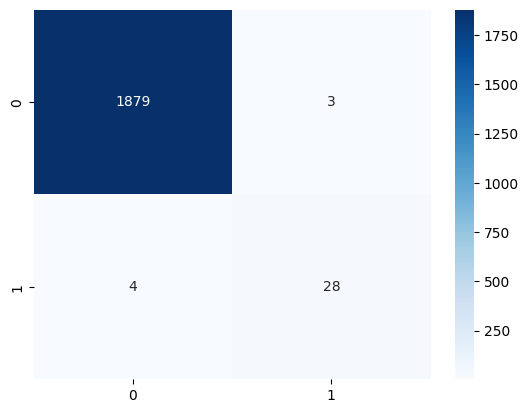

In [60]:
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
model.fit(X_train_bal, y_train_bal)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [61]:
y_test.value_counts()

Intrusion
0    1882
1      32
Name: count, dtype: int64

### LightGBM

In [101]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 13.6 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [83]:
import lightgbm as lgb

lgb_clf = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_estimators=500,
    learning_rate=0.03,
    max_depth=-1,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 126, number of negative: 7530
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 391
[LightGBM] [Info] Number of data points in the train set: 7656, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016458 -> initscore=-4.090368
[LightGBM] [Info] Start training from score -4.090368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

,boosting_type,'gbdt'
,num_leaves,64
,max_depth,-1
,learning_rate,0.03
,n_estimators,500
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1882
           1       1.00      0.88      0.93        32

    accuracy                           1.00      1914
   macro avg       1.00      0.94      0.97      1914
weighted avg       1.00      1.00      1.00      1914



C:\Users\akshi\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


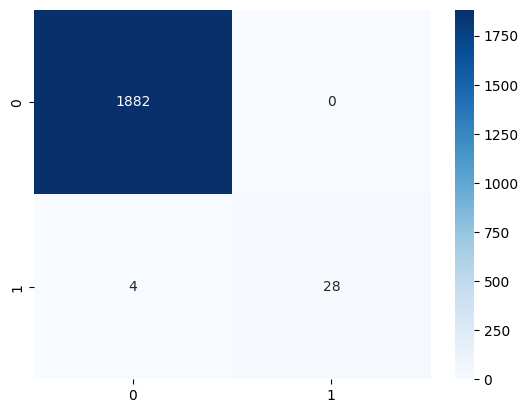

In [84]:
y_pred = lgb_clf.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [85]:
#shap for lightgbm
import shap

# Create a TreeExplainer
explainer = shap.TreeExplainer(lgb_clf)

# Compute SHAP values for test set
shap_values = explainer.shap_values(X_test)


C:\Users\akshi\AppData\Roaming\Python\Python313\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [86]:
shap_values_class1 = shap_values[1]

In [87]:
shap_values_class1

array([ 0.00000000e+00,  0.00000000e+00,  6.10182364e-03,  1.71918110e-03,
       -1.04003116e-01, -2.03744405e-01, -3.50210195e-02,  1.13257876e-02,
       -5.08649107e-03, -9.49808956e-03, -5.38844622e-03,  5.48163288e-02,
        8.36961327e-03, -6.78854342e-03, -1.24534962e-02, -6.27294193e-03,
        6.44270998e-03, -1.29331850e-02, -1.49938038e-04, -4.06044754e-03,
       -9.69791509e-03,  3.74469418e-03,  1.10522501e-02,  3.09630487e-03,
       -6.15758071e-03, -2.32193125e-03, -1.65715368e-03,  4.05639639e-06,
        7.54480076e-05, -3.36987716e-07, -2.28830319e-03, -1.12542998e-02,
       -7.48595597e-02,  0.00000000e+00, -9.64353727e-04, -3.28381468e-02,
       -5.26284458e-03, -1.54023399e-02,  3.85990291e-04, -1.69515589e+00,
       -2.50784329e-01, -4.76465152e-01])

SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (1914, 42)


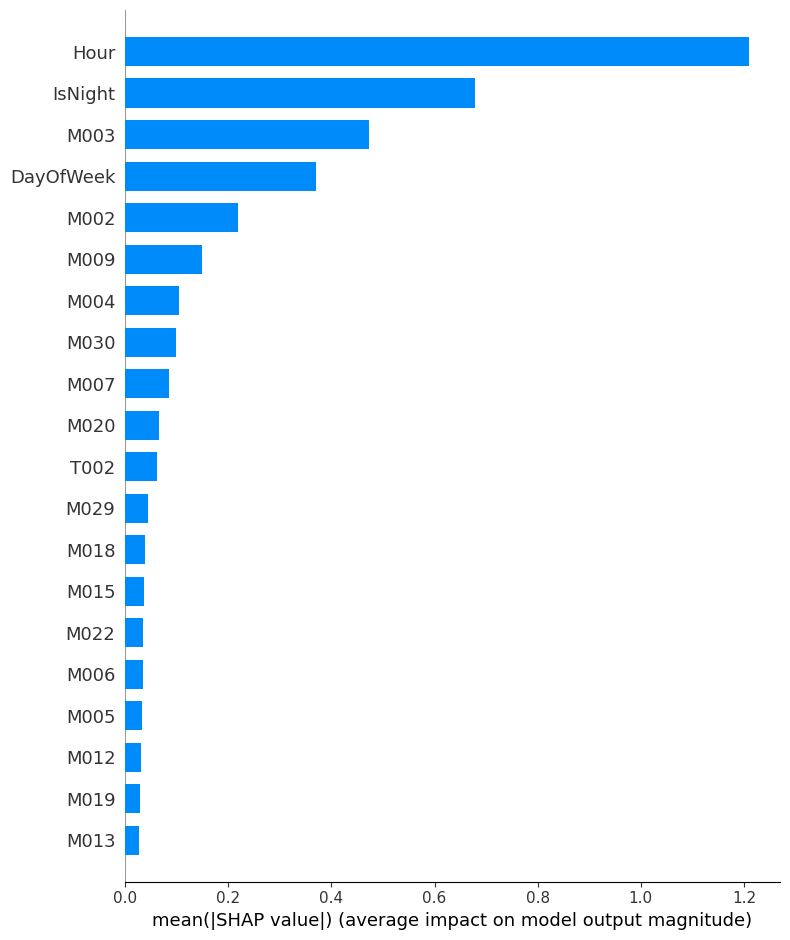

In [88]:
# Plot SHAP values
import matplotlib.pyplot as plt
%matplotlib inline

# Check the shape of shap_values
print(f"SHAP values type: {type(shap_values)}")
if isinstance(shap_values, list):
    print(f"Number of classes: {len(shap_values)}")
    print(f"Class 0 shape: {shap_values[0].shape}")
    print(f"Class 1 shape: {shap_values[1].shape}")
    print(f"X_test shape: {X_test.shape}")
    
    # For binary classification, create plots for both classes
    # Summary plot with bar chart showing feature importance
    print("\n=== SHAP Summary Plot (Bar Chart) ===")
    shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X.columns, show=False)
    plt.tight_layout()
    plt.show()
    
    # Detailed summary plot showing SHAP values distribution
    print("\n=== SHAP Summary Plot (Detailed) ===")
    shap.summary_plot(shap_values[1], X_test, feature_names=X.columns, show=False)
    plt.tight_layout()
    plt.show()
    
else:
    # Single class or already 2D
    print(f"SHAP values shape: {shap_values.shape}")
    shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X.columns, show=False)
    plt.tight_layout()
    plt.show()


How was IsNight, DayofWeek, Hour missed earlier ? Should I include this or not ?, should remove Isnight probably and keep Hour , multicollinearity.

Processing SHAP values (numpy array format, shape: (1914, 42))...
Computing mean SHAP values for both classes...


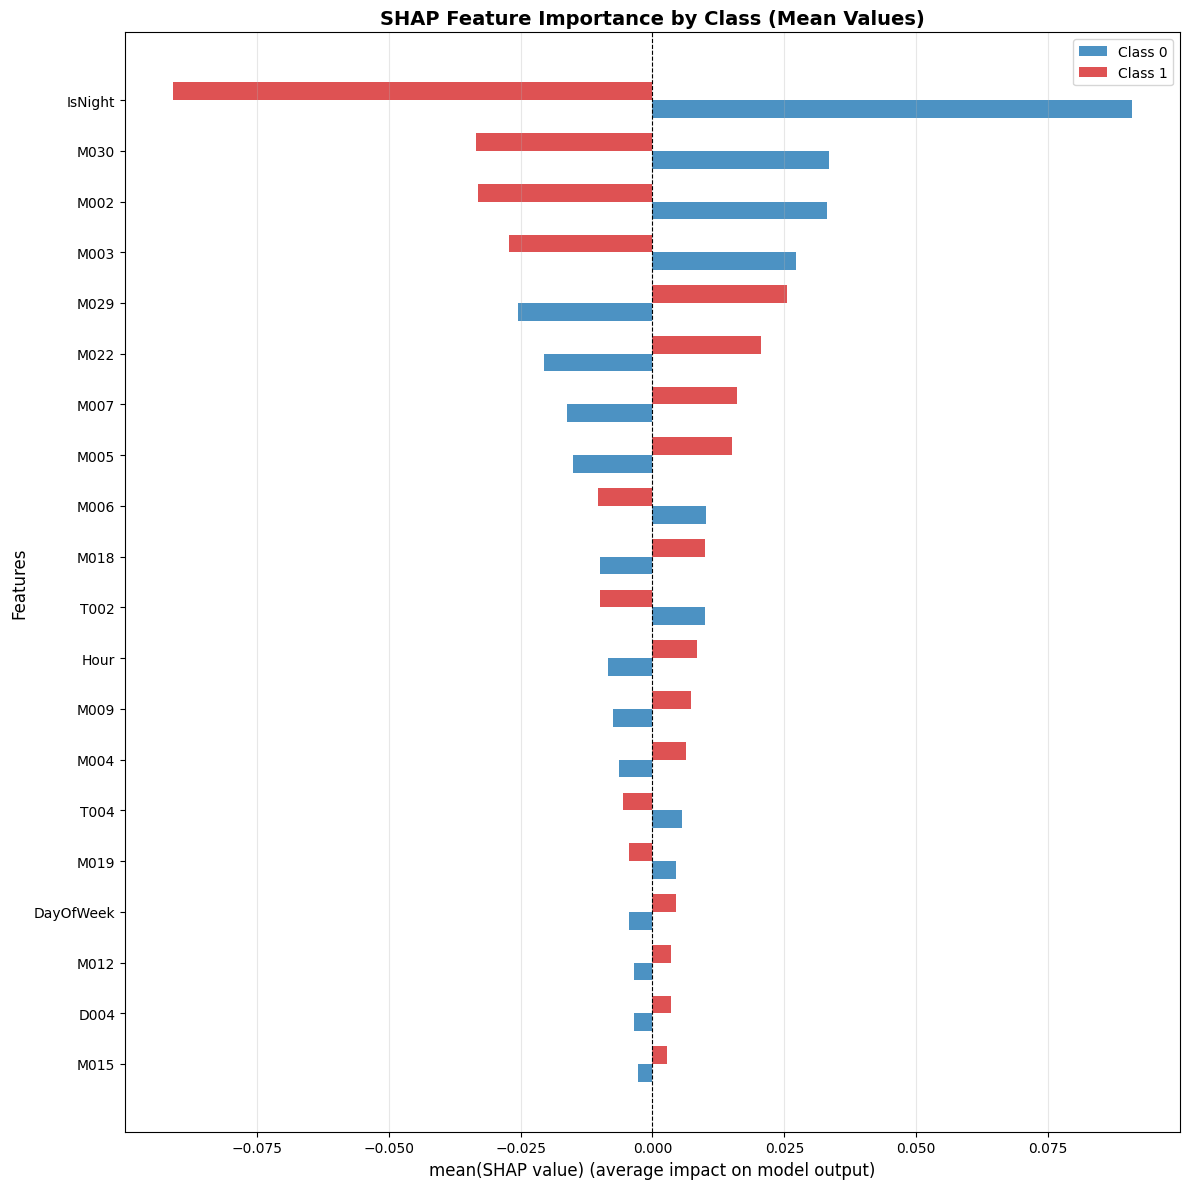

Plot displayed above.

Top 20 features by total absolute SHAP importance:
            Class_0   Class_1
M015      -0.002704  0.002704
D004      -0.003430  0.003430
M012      -0.003434  0.003434
DayOfWeek -0.004401  0.004401
M019       0.004481 -0.004481
T004       0.005530 -0.005530
M004      -0.006408  0.006408
M009      -0.007386  0.007386
Hour      -0.008397  0.008397
T002       0.009867 -0.009867
M018      -0.009878  0.009878
M006       0.010228 -0.010228
M005      -0.015106  0.015106
M007      -0.016115  0.016115
M022      -0.020580  0.020580
M029      -0.025526  0.025526
M003       0.027184 -0.027184
M002       0.033026 -0.033026
M030       0.033512 -0.033512
IsNight    0.090904 -0.090904


In [89]:
# Alternative: Handle numpy array format for SHAP values
# If the previous cell showed an error, run this cell instead

if isinstance(shap_values, np.ndarray) and len(shap_values.shape) == 2:
    print(f"Processing SHAP values (numpy array format, shape: {shap_values.shape})...")
    
    # For 2D array in binary classification, the values are typically for the positive class (class 1)
    # In binary classification, SHAP values for class 0 are often the negative of class 1
    print("Computing mean SHAP values for both classes...")
    mean_shap_class1 = pd.Series(shap_values.mean(axis=0), index=X.columns)
    mean_shap_class0 = -mean_shap_class1  # In binary classification, they're typically negatives
    
    # Combine into DataFrame
    shap_importance = pd.DataFrame({
        'Class_0': mean_shap_class0,
        'Class_1': mean_shap_class1
    })
    
    # Calculate total absolute importance for sorting
    shap_importance['Total_Abs'] = np.abs(shap_importance['Class_0']) + np.abs(shap_importance['Class_1'])
    shap_importance = shap_importance.sort_values('Total_Abs', ascending=True)
    
    # Plot side-by-side horizontal bar chart
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Get top N features
    top_n = 20
    shap_top = shap_importance.tail(top_n)
    
    # Create side-by-side bars
    y_pos = np.arange(len(shap_top))
    width = 0.35
    
    bars0 = ax.barh(y_pos - width/2, shap_top['Class_0'], width, 
                    label='Class 0', color='#1f77b4', alpha=0.8)
    bars1 = ax.barh(y_pos + width/2, shap_top['Class_1'], width,
                    label='Class 1', color='#d62728', alpha=0.8)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(shap_top.index)
    ax.set_xlabel('mean(SHAP value) (average impact on model output)', fontsize=12)
    ax.set_ylabel('Features', fontsize=12)
    ax.set_title('SHAP Feature Importance by Class (Mean Values)', fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(axis='x', alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    
    plt.tight_layout()
    plt.show()
    print("Plot displayed above.")
    
    print(f"\nTop {top_n} features by total absolute SHAP importance:")
    print(shap_top[['Class_0', 'Class_1']].to_string())
else:
    print("This cell is for numpy array format. If shap_values is a list, use the previous cell.")


In [101]:
#Retrain lightgbm with top features
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
if isinstance(shap_values, list):  
    shap_values_sum = sum([abs(class_shap).mean(axis=0) for class_shap in shap_values])
else:
    shap_values_sum = abs(shap_values).mean(axis=0)

shap_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': shap_values_sum
}).sort_values(by='importance', ascending=False)

# 5. Select top features (e.g., top 20)
top_features = shap_importance['feature'].iloc[:20].tolist()
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 126, number of negative: 7530
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 7656, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016458 -> initscore=-4.090368
[LightGBM] [Info] Start training from score -4.090368
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training beca

C:\Users\akshi\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\akshi\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\akshi\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

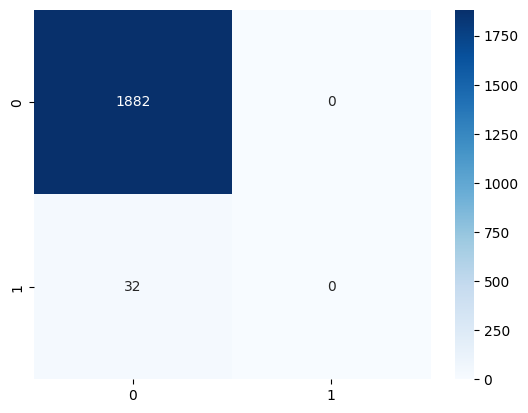

In [ ]:
# # 6. Retrain model with top features
# lgb_clf.fit(X_train, y_train)

# # 7. Evaluate
# y_pred = lgb_clf.predict(X_test)
# print(classification_report(y_test, y_pred))
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.show()

In [ ]:
# #Retrain lightgbm with top features
# X_train = pd.DataFrame(X_train, columns=X.columns)
# X_test = pd.DataFrame(X_test)
# if isinstance(shap_values, list):  
#     shap_values_sum = sum([abs(class_shap).mean(axis=0) for class_shap in shap_values])
# else:
#     shap_values_sum = abs(shap_values).mean(axis=0)

# shap_importance = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': shap_values_sum
# }).sort_values(by='importance', ascending=False)

# # 5. Select top features (e.g., top 20)
# top_features = shap_importance['feature'].iloc[:20].tolist()
# X_train_top = X_train[top_features]
# X_test_top = X_test[top_features]res:
#         recompute_shap = False
#         print(f"Using existing SHAP values (length: {test_len})")
#     else:
#         print(f"SHAP values length ({test_len}) doesn't match features ({num_features}). Recomputing...")

# # Recompute SHAP values on full dataset if needed
# if recompute_shap:
#     print("Computing SHAP values on full feature set...")
#     # Make sure we have the model trained on full features
#     if 'lgb_clf' in globals():
#         explainer = shap.TreeExplainer(lgb_clf)
#         shap_values = explainer.shap_values(X_test)
#         print(f"Computed SHAP values with shape: {shap_values[0].shape if isinstance(shap_values, list) else shap_values.shape}")
#     else:
#         print("Error: lgb_clf model not found. Cannot compute SHAP values.")
#         raise NameError("lgb_clf model not found. Train the model first.")

# # Calculate SHAP importance
# if isinstance(shap_values, list):  
#     shap_values_sum = sum([abs(class_shap).mean(axis=0) for class_shap in shap_values])
# else:
#     shap_values_sum = abs(shap_values).mean(axis=0)

# # Ensure shap_values_sum has the same length as X_train.columns
# shap_values_sum = np.array(shap_values_sum).flatten()

# if len(shap_values_sum) != num_features:
#     print(f"Error: SHAP values length ({len(shap_values_sum)}) still doesn't match features ({num_features})")
#     raise ValueError(f"SHAP values and features have mismatched lengths")

# shap_importance = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': shap_values_sum
# }).sort_values(by='importance', ascending=False)

# # 5. Select top 10 features
# top_features = shap_importance['feature'].iloc[:10].tolist()
# print(f"\nSelected top {len(top_features)} features:")
# print(top_features)

# # Create subsets with proper column names
# X_train_top = X_train[top_features].copy()
# X_test_top = X_test[top_features].copy()

# # Ensure column names are preserved
# X_train_top.columns = top_features
# X_test_top.columns = top_features

# print(f"\nX_train_top shape: {X_train_top.shape}, columns: {list(X_train_top.columns)}")
# print(f"X_test_top shape: {X_test_top.shape}, columns: {list(X_test_top.columns)}")

SyntaxError: invalid syntax (953824421.py, line 26)

In [97]:
#Retrain lightgbm with top features
import numpy as np
import shap

# Preserve original column names when converting to DataFrame
# Get original column names from X (before scaling)
if 'X' in globals() and hasattr(X, 'columns'):
    original_columns = X.columns.tolist()
    X_train = pd.DataFrame(X_train, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)
else:
    # Fallback: use numeric indices if original columns not available
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    print("Warning: Using numeric column indices.")

# Calculate SHAP importance on the FULL dataset (before feature selection)
# Check if shap_values exists and has the right length
num_features = len(X_train.columns)
recompute_shap = True

if 'shap_values' in globals():
    if isinstance(shap_values, list):
        test_len = shap_values[0].shape[1] if len(shap_values) > 0 else 0
    else:
        test_len = shap_values.shape[1] if len(shap_values.shape) > 1 else len(shap_values)
    
    if test_len == num_features:
        recompute_shap = False
        print(f"Using existing SHAP values (length: {test_len})")
    else:
        print(f"SHAP values length ({test_len}) doesn't match features ({num_features}). Recomputing...")

# Recompute SHAP values on full dataset if needed
if recompute_shap:
    print("Computing SHAP values on full feature set...")
    # Make sure we have the model trained on full features
    if 'lgb_clf' in globals():
        explainer = shap.TreeExplainer(lgb_clf)
        shap_values = explainer.shap_values(X_test)
        print(f"Computed SHAP values with shape: {shap_values[0].shape if isinstance(shap_values, list) else shap_values.shape}")
    else:
        print("Error: lgb_clf model not found. Cannot compute SHAP values.")
        raise NameError("lgb_clf model not found. Train the model first.")

# Calculate SHAP importance
if isinstance(shap_values, list):  
    shap_values_sum = sum([abs(class_shap).mean(axis=0) for class_shap in shap_values])
else:
    shap_values_sum = abs(shap_values).mean(axis=0)

# Ensure shap_values_sum has the same length as X_train.columns
shap_values_sum = np.array(shap_values_sum).flatten()

if len(shap_values_sum) != num_features:
    print(f"Error: SHAP values length ({len(shap_values_sum)}) still doesn't match features ({num_features})")
    raise ValueError(f"SHAP values and features have mismatched lengths")

shap_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': shap_values_sum
}).sort_values(by='importance', ascending=False)

# 5. Select top 10 features
top_features = shap_importance['feature'].iloc[:20].tolist()
print(f"\nSelected top {len(top_features)} features:")
print(top_features)

# Create subsets with proper column names
X_train_top = X_train[top_features].copy()
X_test_top = X_test[top_features].copy()

# Ensure column names are preserved
X_train_top.columns = top_features
X_test_top.columns = top_features

print(f"\nX_train_top shape: {X_train_top.shape}, columns: {list(X_train_top.columns)}")
print(f"X_test_top shape: {X_test_top.shape}, columns: {list(X_test_top.columns)}")

Using existing SHAP values (length: 42)

Selected top 20 features:
['Hour', 'IsNight', 'M003', 'DayOfWeek', 'M002', 'M009', 'M004', 'M030', 'M007', 'M020', 'T002', 'M029', 'M018', 'M015', 'M022', 'M006', 'M005', 'M012', 'M019', 'M013']

X_train_top shape: (7656, 20), columns: ['Hour', 'IsNight', 'M003', 'DayOfWeek', 'M002', 'M009', 'M004', 'M030', 'M007', 'M020', 'T002', 'M029', 'M018', 'M015', 'M022', 'M006', 'M005', 'M012', 'M019', 'M013']
X_test_top shape: (1914, 20), columns: ['Hour', 'IsNight', 'M003', 'DayOfWeek', 'M002', 'M009', 'M004', 'M030', 'M007', 'M020', 'T002', 'M029', 'M018', 'M015', 'M022', 'M006', 'M005', 'M012', 'M019', 'M013']


Retraining LightGBM with top 10 features...
Training on 7656 samples with 20 features
Feature names: ['Hour', 'IsNight', 'M003', 'DayOfWeek', 'M002', 'M009', 'M004', 'M030', 'M007', 'M020', 'T002', 'M029', 'M018', 'M015', 'M022', 'M006', 'M005', 'M012', 'M019', 'M013']
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 126, number of negative: 7530
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 7656, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016458 -> initscore=-4.090368
[LightGBM] [Info] Start training from score -4.090368
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the

C:\Users\akshi\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\akshi\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\akshi\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

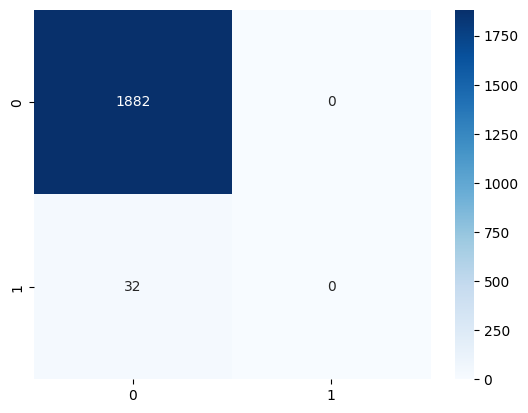


Model trained successfully with 20 features: ['Hour', 'IsNight', 'M003', 'DayOfWeek', 'M002', 'M009', 'M004', 'M030', 'M007', 'M020', 'T002', 'M029', 'M018', 'M015', 'M022', 'M006', 'M005', 'M012', 'M019', 'M013']

Model trained successfully with 20 features: ['Hour', 'IsNight', 'M003', 'DayOfWeek', 'M002', 'M009', 'M004', 'M030', 'M007', 'M020', 'T002', 'M029', 'M018', 'M015', 'M022', 'M006', 'M005', 'M012', 'M019', 'M013']


In [ ]:
# # 6. Retrain model with top 10 features
# # Ensure we have a fresh model instance for retraining
# import lightgbm as lgb

# print("Retraining LightGBM with top 10 features...")
# print(f"Training on {X_train_top.shape[0]} samples with {X_train_top.shape[1]} features")
# print(f"Feature names: {list(X_train_top.columns)}")

# # Train on the top 20 features
# lgb_clf.fit(X_train_top, y_train)


# # 7. Evaluate
# print("\nEvaluating model with top 10 features...")
# y_pred = lgb_clf.predict(X_test_top)
# print(classification_report(y_test, y_pred))
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.show()

# print(f"\nModel trained successfully with {len(X_train_top.columns)} features: {list(X_train_top.columns)}")



# print(f"\nModel trained successfully with {len(X_train_top.columns)} features: {list(X_train_top.columns)}")



In [ ]:
# # 6. Retrain model with top 10 features
# # Ensure we have a fresh model instance for retraining
# import lightgbm as lgb

# print("Retraining LightGBM with top 10 features...")
# print(f"Training on {X_train_top.shape[0]} samples with {X_train_top.shape[1]} features")
# print(f"Feature names: {list(X_train_top.columns)}")

# # Create a new model instance for retraining
# lgb_clf_top20 = lgb.LGBMClassifier(
#     objective='binary',
#     boosting_type='gbdt',
#     n_estimators=500,
#     learning_rate=0.03,
#     max_depth=-1,
#     num_leaves=64,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42
# )

# # Train on the top 10 features
# lgb_clf_top20.fit(X_train_top, y_train)

# # Update the main model variable
# lgb_clf = lgb_clf_top20

# # 7. Evaluate
# print("\nEvaluating model with top 10 features...")
# y_pred = lgb_clf.predict(X_test_top)
# print(classification_report(y_test, y_pred))
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.show()

# print(f"\nModel trained successfully with {len(X_train_top.columns)} features: {list(X_train_top.columns)}")



In [159]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1882
           1       0.00      0.00      0.00        32

    accuracy                           0.98      1914
   macro avg       0.49      0.50      0.50      1914
weighted avg       0.97      0.98      0.97      1914



C:\Users\akshi\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\akshi\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\akshi\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

### Mistral

In [132]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline,  AutoModelForCausalLM


In [102]:
X_train_top

,Hour,IsNight,M003,DayOfWeek,M002,M009,M004,M030,M007,M020,T002,M029,M018,M015,M022,M006,M005,M012,M019,M013
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
x_sample = X_test_top.iloc[0:1]
y_pred = lgb_clf.predict(x_sample)[0]

LightGBMError: The number of features in data (20) is not the same as it was in training data (42).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [131]:
!pip install tf-keras

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 20.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [95]:
explainer = shap.TreeExplainer(lgb_clf)
shap_values = explainer.shap_values(x_sample)

features = x_sample.to_dict(orient='records')[0]
print(f"\nFeature names in dictionary (first 5): {list(features.keys())[:5]}")
print(f"Total features: {len(features)}")

# Extract actual feature names from indices
# Check if X_test_top.columns are numeric indices or feature names
import numpy as np

# Determine if columns are numeric indices
is_numeric_index = False
try:
    # Try to check if columns are numeric
    if X_test_top.columns.dtype in ['int64', 'int32', 'float64', 'float32']:
        is_numeric_index = True
    elif all(isinstance(col, (int, float)) for col in X_test_top.columns):
        is_numeric_index = True
except:
    # If check fails, assume they might be numeric
    is_numeric_index = any(isinstance(col, (int, float)) for col in X_test_top.columns)

if is_numeric_index:
    # Columns are numeric indices - map to actual feature names
    if 'top_features' in globals():
        # Use top_features list to map indices to names
        feature_names = [top_features[i] if i < len(top_features) else f'Feature_{i}' 
                        for i in X_test_top.columns]
        print(f"Mapping numeric indices to feature names using top_features")
    elif 'X' in globals() and hasattr(X, 'columns'):
        # Fallback: use original X.columns if top_features not available
        feature_names = [X.columns[i] if i < len(X.columns) else f'Feature_{i}' 
                        for i in X_test_top.columns]
        print(f"Mapping numeric indices to feature names using X.columns")
    else:
        # Last resort: use column indices as strings
        feature_names = [str(col) for col in X_test_top.columns]
        print(f"Warning: Using column indices as feature names")
    print(f"Feature names (first 5): {feature_names[:5]}...")
else:
    # Columns are already feature names
    feature_names = X_test_top.columns.tolist()
    print(f"Using existing feature names: {feature_names[:5]}...")


# Handle different SHAP output formats
import numpy as np
if isinstance(shap_values, list):
    # List format: shap_values[0] for class 0, shap_values[1] for class 1
    if len(shap_values) > 1:
        shap_contribs = dict(zip(X_test_top.columns, shap_values[1][0]))  # class 1 for binary
    else:
        shap_contribs = dict(zip(X_test_top.columns, shap_values[0][0]))
elif isinstance(shap_values, np.ndarray):
    # Single array format - check dimensions
    if len(shap_values.shape) == 2:
        # 2D array: (samples, features) - use first sample
        shap_contribs = dict(zip(X_test_top.columns, shap_values[0]))
    elif len(shap_values.shape) == 3:
        # 3D array: (samples, features, classes) - use class 1
        shap_contribs = dict(zip(X_test_top.columns, shap_values[0, :, 1]))
    else:
        # 1D array: (features,) - use directly
        shap_contribs = dict(zip(X_test_top.columns, shap_values))
else:
    raise ValueError(f"Unexpected shap_values type: {type(shap_values)}")

print(f"Successfully created shap_contribs with {len(shap_contribs)} features")


NameError: name 'x_sample' is not defined

In [143]:
shap_contribs

{5: np.float64(-0.2298100045508408),
 4: np.float64(-0.12629994312315598),
 6: np.float64(-0.12740841632947475),
 11: np.float64(0.32857566405466804),
 9: np.float64(0.012687571245833657),
 12: np.float64(0.15005321234807759),
 16: np.float64(0.15344475191051515),
 32: np.float64(-0.03825064870824733),
 8: np.float64(0.019861707655011444),
 31: np.float64(-0.027961198022631837),
 22: np.float64(0.20441744229658917),
 7: np.float64(0.02038021084470699),
 17: np.float64(0.05581480215983859),
 20: np.float64(-0.018794229365228215),
 21: np.float64(0.08195778009378198),
 13: np.float64(-0.008592889885899364),
 24: np.float64(0.06102131859379689),
 35: np.float64(0.019107561669852155),
 15: np.float64(-0.001186427025680619),
 14: np.float64(-0.029142520827496805)}

In [138]:
prompt = f"""
The model predicted {y_pred} for this instance.
Feature values: {features}
SHAP contributions: {shap_contribs}

Explain in simple terms why this prediction was made and highlight the most influential features.
"""

In [140]:
# Use HuggingFace Inference API to avoid loading the model locally
# This solves memory issues by running the model on HuggingFace servers
# Note: You can use this for free, but rate limits apply. For production, get an API token.

from huggingface_hub import InferenceClient
import json

# Model name
model_name = "mistralai/Mistral-7B-Instruct-v0.1"

print("Using HuggingFace Inference API (no local model loading required)...")
print("Note: This requires an internet connection and uses HuggingFace's servers.")

# Initialize the inference client
# If you have a HuggingFace token, you can use it for better rate limits:
# client = InferenceClient(token="your_token_here")
client = InferenceClient()

# Format the prompt for Mistral Instruct
# Mistral uses a specific chat format
formatted_prompt = f"<s>[INST] {prompt} [/INST]"

print("Generating explanation...")
try:
    # Generate response using the API
    response = client.text_generation(
        formatted_prompt,
        model=model_name,
        max_new_tokens=512,
        temperature=0.7,
        top_p=0.9,
        do_sample=True,
        return_full_text=False  # Only return the generated text, not the prompt
    )
    
    explanation = response.strip()
    
    print("\n" + "="*80)
    print("MISTRAL EXPLANATION:")
    print("="*80)
    print(explanation)
    print("="*80)
    
except Exception as e:
    print(f"Error using Inference API: {e}")
    print("\nTrying alternative: Using requests to call the API directly...")
    
    # Alternative: Use requests library if InferenceClient doesn't work
    import requests
    
    API_URL = f"https://api-inference.huggingface.co/models/{model_name}"
    headers = {"Content-Type": "application/json"}
    
    # Format prompt for the API
    payload = {
        "inputs": formatted_prompt,
        "parameters": {
            "max_new_tokens": 512,
            "temperature": 0.7,
            "top_p": 0.9,
            "return_full_text": False
        }
    }
    
    try:
        response = requests.post(API_URL, headers=headers, json=payload)
        response.raise_for_status()
        result = response.json()
        
        if isinstance(result, list) and len(result) > 0:
            explanation = result[0].get('generated_text', '').strip()
        elif isinstance(result, dict):
            explanation = result.get('generated_text', '').strip()
        else:
            explanation = str(result)
        
        print("\n" + "="*80)
        print("MISTRAL EXPLANATION:")
        print("="*80)
        print(explanation)
        print("="*80)
        
    except Exception as e2:
        print(f"Error with requests API: {e2}")
        print("\n" + "="*80)
        print("ALTERNATIVE: Manual explanation based on SHAP values")
        print("="*80)
        
        # Fallback: Create a simple explanation from SHAP values
        top_features = sorted(shap_contribs.items(), key=lambda x: abs(x[1]), reverse=True)[:5]
        explanation = f"""
Based on the model prediction ({y_pred}) and SHAP analysis:

The model predicted this instance as {'an ANOMALY' if y_pred == 1 else 'NORMAL'}.

Top contributing features:
"""
        for feature, value in top_features:
            direction = "increases" if value > 0 else "decreases"
            explanation += f"- {feature}: {value:.4f} ({direction} anomaly probability)\n"
        
        explanation += "\nThis prediction is primarily driven by the features listed above."
        print(explanation)
        print("="*80)


Using HuggingFace Inference API (no local model loading required)...
Note: This requires an internet connection and uses HuggingFace's servers.
Generating explanation...
Error using Inference API: 

Trying alternative: Using requests to call the API directly...
Error with requests API: 410 Client Error: Gone for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.1

ALTERNATIVE: Manual explanation based on SHAP values

Based on the model prediction (0) and SHAP analysis:

The model predicted this instance as NORMAL.

Top contributing features:
- 11: 0.3286 (increases anomaly probability)
- 5: -0.2298 (decreases anomaly probability)
- 22: 0.2044 (increases anomaly probability)
- 16: 0.1534 (increases anomaly probability)
- 12: 0.1501 (increases anomaly probability)

This prediction is primarily driven by the features listed above.
